In [1]:
%load_ext autoreload
%autoreload 2

# Visualise the 2 circuits for ruggedness

In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict


In [3]:
# dir_rugg = 'data/ruggedness/2025_07_02__11_24_20'
# dir_rugg = 'data/ruggedness/2025_07_02__13_25_02'
# dir_rugg = 'data/ruggedness/2025_07_02__14_14_21'
dir_rugg = 'data/ruggedness/2025_07_31__14_30_21'

ys = np.load(os.path.join(dir_rugg, 'batch_0', 'ys.npy'))
ts = np.load(os.path.join(dir_rugg, 'batch_0', 'ts.npy'))
t_max_show = 2000
t_max_i = np.where(ts < t_max_show)[-1][-1]
config = load_json_as_dict(os.path.join(dir_rugg, 'config.json'))

In [4]:
ys.shape

(40002, 500, 9)

In [5]:
resimulate_analytics = config.get('resimulate_analytics', False)
n_samples = 2
n_perturbs = ys.shape[0] // n_samples
idx_output = -1
ys = ys.reshape(n_samples, n_perturbs, ys.shape[-2], ys.shape[-1])
n_perturbs

20001

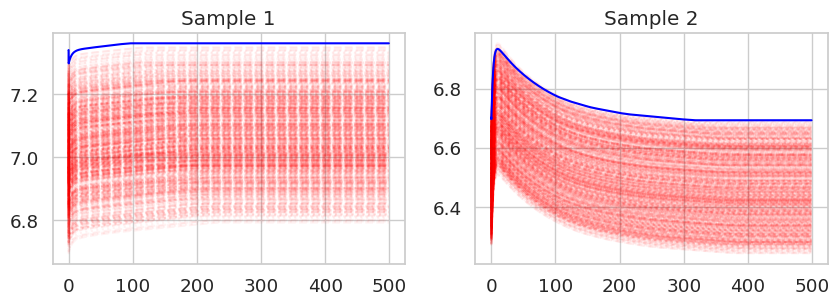

In [15]:
sns.set_context('notebook', font_scale=1.2)
sns.set_style('whitegrid')

fig, axs = plt.subplots(1, n_samples, figsize=(5 * n_samples, 3), sharex=True)

for i_samp in range(n_samples):
    ax = axs[i_samp]

    for crugg in np.concatenate([np.arange(100), np.arange(n_perturbs - 800, n_perturbs)]): #n_perturbs):

        is_og = crugg == (n_perturbs -1)
        
        ys_p = ys[i_samp, crugg, :t_max_i + 1, idx_output]
        # ys_p = np.interp(ys_p, (ys_p.min(), ys_p.max()), (0, 1))
        sns.lineplot(x=ts[:t_max_i + 1], y=ys_p,
                     ax=ax, alpha=1 if is_og else 0.05,
                     linestyle=('--' if np.mod(crugg, 2) == 0 else 'dotted') if not(is_og) else '-',
                     color='b' if is_og else 'r')

    ax.set_title(f'Sample {i_samp + 1}') # ({config["fn_circuits"][i_samp].split("_")[-1].split(".")[0] })')

<Axes: >

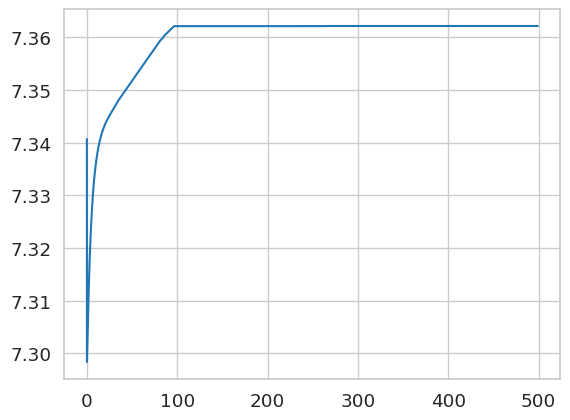

In [14]:
ys_p = ys[0, -1, :t_max_i + 1, idx_output]
# ys_p = np.interp(ys_p, (0, ys_p.max()), (0, 1))
sns.lineplot(x=ts[:t_max_i + 1], y=ys_p)